In [1]:
!git clone https://github.com/JASCRAJ/stylized-neural-painting.git

Cloning into 'stylized-neural-painting'...
remote: Enumerating objects: 221, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 221 (delta 85), reused 61 (delta 61), pack-reused 110 (from 1)
Receiving objects: 100% (221/221), 10.59 MiB | 26.20 MiB/s, done.
Resolving deltas: 100% (115/115), done.


In [2]:
cd stylized-neural-painting

/content/stylized-neural-painting


 Renderer working — saved to test_renderer_output.png


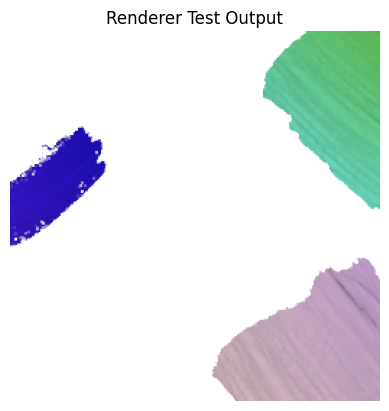

In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from renderer import Renderer

brush_files = [
    "./brushes/brush_fromweb2_small_vertical.png",
    "./brushes/brush_fromweb2_small_horizontal.png",
    "./brushes/brush_fromweb2_large_vertical.png",
    "./brushes/brush_fromweb2_large_horizontal.png"
]

# Initialize renderer
renderer = Renderer(renderer='oilpaintbrush', CANVAS_WIDTH=256, canvas_color='white')

# Drawing  a few random strokes
num_strokes = 3
for _ in range(num_strokes):
    renderer.random_stroke_params()
    if renderer.check_stroke():
        renderer.draw_stroke()

# Saving the rendered canvas
canvas = renderer.canvas
img_uint8 = (canvas * 255).astype(np.uint8)
Image.fromarray(img_uint8).save("test_renderer_output.png")
print(" Renderer working — saved to test_renderer_output.png")

# display
plt.imshow(canvas)
plt.title("Renderer Test Output")
plt.axis("off")
plt.show()


✅ Rendered 1500 strokes — saved to rendered_strokes_output.png


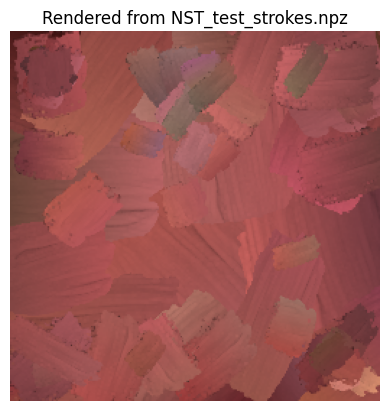

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from renderer import Renderer

# --- Load stroke parameters ---
data = np.load("NST_test_strokes.npz")
x_ctt = data["x_ctt"]     # [25, 60, 5]
x_color = data["x_color"] # [25, 60, 6]
x_alpha = data["x_alpha"] # [25, 60, 1]

# --- Reshape into [total_strokes, 12] ---
x_ctt = x_ctt.reshape(-1, 5)     # [1500, 5]
x_color = x_color.reshape(-1, 6) # [1500, 6]
x_alpha = x_alpha.reshape(-1, 1) # [1500, 1]
strokes = np.concatenate([x_ctt, x_color, x_alpha], axis=-1)  # [1500, 12]

# --- Initialize Renderer ---
renderer = Renderer(renderer='oilpaintbrush', CANVAS_WIDTH=256, canvas_color='white')
renderer.create_empty_canvas()

# --- Render all strokes ---
for i in range(strokes.shape[0]):
    params = strokes[i].astype(np.float32).flatten()
    if params.shape[0] != 12:
        print(f"Skipping stroke {i}: wrong shape {params.shape}")
        continue
    renderer.stroke_params = params
    if renderer.check_stroke():
        renderer.draw_stroke()

# --- Save output image ---
canvas = renderer.canvas
img_uint8 = (canvas * 255).astype(np.uint8)
Image.fromarray(img_uint8).save("rendered_strokes_output.png")
print("✅ Rendered 1500 strokes — saved to rendered_strokes_output.png")

# --- Optionally show it ---
plt.imshow(canvas)
plt.title("Rendered from NST_test_strokes.npz")
plt.axis("off")
plt.show()


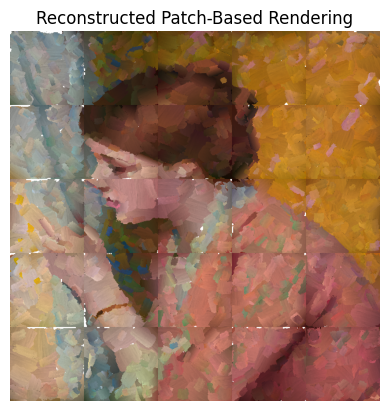

In [13]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from renderer import Renderer  # Make sure this file is available

# --- Load stroke parameters ---
data = np.load("NST_test_strokes.npz")
x_ctt = data["x_ctt"]     # shape: [25, 60, 5]
x_color = data["x_color"] # shape: [25, 60, 6]
x_alpha = data["x_alpha"] # shape: [25, 60, 1]

# --- Patch/grid setup ---
num_patches = x_ctt.shape[0]      # 25
strokes_per_patch = x_ctt.shape[1]  # 60
patch_size = 128
grid_w = grid_h = int(np.sqrt(num_patches))  # 5×5
canvas_size = patch_size * grid_h

# --- Create full canvas ---
final_canvas = np.zeros((canvas_size, canvas_size, 3), dtype=np.float32)

# --- Render strokes for each patch ---
for patch_idx in range(num_patches):
    strokes = np.concatenate([x_ctt[patch_idx], x_color[patch_idx], x_alpha[patch_idx]], axis=-1)

    renderer = Renderer(renderer='oilpaintbrush', CANVAS_WIDTH=patch_size, canvas_color='white')
    renderer.create_empty_canvas()

    for stroke in strokes:
        stroke = np.array(stroke).astype(np.float32).flatten()
        if stroke.shape[0] != 12:
            continue
        renderer.stroke_params = stroke
        if renderer.check_stroke():
            renderer.draw_stroke()

    # Place this patch into the full canvas
    row = patch_idx // grid_w
    col = patch_idx % grid_w
    y, x = row * patch_size, col * patch_size
    final_canvas[y:y+patch_size, x:x+patch_size, :] = renderer.canvas

# --- Save and show ---
img_uint8 = (final_canvas * 255).clip(0, 255).astype(np.uint8)
Image.fromarray(img_uint8).save("reconstructed_from_patches.png")
plt.imshow(final_canvas)
plt.title("Reconstructed Patch-Based Rendering")
plt.axis("off")
plt.show()


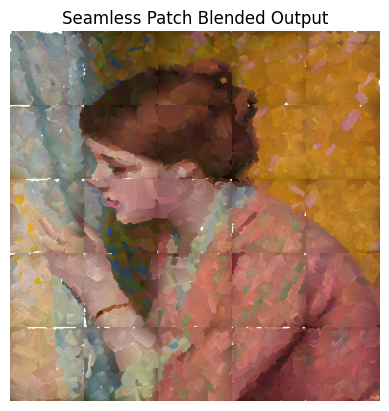

In [15]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from renderer import Renderer

# --- Load stroke data ---
data = np.load("NST_test_strokes.npz")
x_ctt = data["x_ctt"]     # [25, 60, 5]
x_color = data["x_color"] # [25, 60, 6]
x_alpha = data["x_alpha"] # [25, 60, 1]

# --- Configuration ---
num_patches = x_ctt.shape[0]
strokes_per_patch = x_ctt.shape[1]
patch_size = 128
grid_h = grid_w = int(np.sqrt(num_patches))  # 5x5 grid
canvas_size = patch_size * grid_h
final_canvas = np.zeros((canvas_size, canvas_size, 3), dtype=np.float32)
weight_canvas = np.zeros_like(final_canvas)

# --- Render each patch and blend into final canvas ---
for patch_idx in range(num_patches):
    strokes = np.concatenate([x_ctt[patch_idx], x_color[patch_idx], x_alpha[patch_idx]], axis=-1)

    # Create local renderer for patch
    renderer = Renderer(renderer='oilpaintbrush', CANVAS_WIDTH=patch_size, canvas_color='white')
    renderer.create_empty_canvas()

    for stroke in strokes:
        stroke = np.array(stroke).astype(np.float32).flatten()
        if stroke.shape[0] != 12:
            continue
        renderer.stroke_params = stroke
        if renderer.check_stroke():
            renderer.draw_stroke()

    # Determine patch position on full canvas
    row = patch_idx // grid_w
    col = patch_idx % grid_w
    y_start = row * patch_size
    x_start = col * patch_size

    # Blend patch into full canvas (accumulate RGB and weight)
    final_canvas[y_start:y_start+patch_size, x_start:x_start+patch_size, :] += renderer.canvas
    weight_canvas[y_start:y_start+patch_size, x_start:x_start+patch_size, :] += 1.0

# --- Normalize blended regions ---
final_canvas = np.divide(final_canvas, weight_canvas, out=np.zeros_like(final_canvas), where=weight_canvas > 0)

# --- Save and show ---
output_img = (final_canvas * 255).clip(0, 255).astype(np.uint8)
Image.fromarray(output_img).save("seamless_blended_output.png")

plt.imshow(final_canvas)
plt.title("Seamless Patch Blended Output")
plt.axis("off")
plt.show()


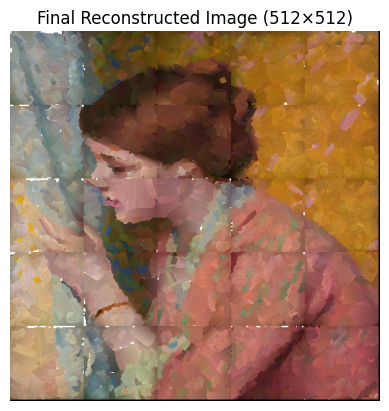

In [16]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from renderer import Renderer

# --- Load stroke data ---
data = np.load("NST_test_strokes.npz")
x_ctt = data["x_ctt"]     # [25, 60, 5]
x_color = data["x_color"] # [25, 60, 6]
x_alpha = data["x_alpha"] # [25, 60, 1]

# --- Patch/grid configuration ---
num_patches = x_ctt.shape[0]        # 25
strokes_per_patch = x_ctt.shape[1]  # 60
grid = 5
patch_size = 512 // grid            # 102
canvas_size = 512                   # full canvas

# --- Initialize output and weight canvases ---
final_canvas = np.zeros((canvas_size, canvas_size, 3), dtype=np.float32)
weight_canvas = np.zeros_like(final_canvas)

# --- Render and blend each patch ---
for patch_idx in range(num_patches):
    strokes = np.concatenate([x_ctt[patch_idx], x_color[patch_idx], x_alpha[patch_idx]], axis=-1)

    # Initialize renderer for this patch
    renderer = Renderer(renderer='oilpaintbrush', CANVAS_WIDTH=patch_size, canvas_color='white')
    renderer.create_empty_canvas()

    for stroke in strokes:
        stroke = np.array(stroke).astype(np.float32).flatten()
        if stroke.shape[0] != 12:
            continue
        renderer.stroke_params = stroke
        if renderer.check_stroke():
            renderer.draw_stroke()

    # Compute position to place this patch
    row = patch_idx // grid
    col = patch_idx % grid
    y_start = row * patch_size
    x_start = col * patch_size

    # Blend into final canvas
    final_canvas[y_start:y_start+patch_size, x_start:x_start+patch_size, :] += renderer.canvas
    weight_canvas[y_start:y_start+patch_size, x_start:x_start+patch_size, :] += 1.0

# --- Normalize blended regions ---
final_canvas = np.divide(final_canvas, weight_canvas, out=np.zeros_like(final_canvas), where=weight_canvas > 0)

# --- Save and show result ---
output_img = (final_canvas * 255).clip(0, 255).astype(np.uint8)
Image.fromarray(output_img).save("nst_reconstructed_512.png")

plt.imshow(final_canvas)
plt.title("Final Reconstructed Image (512×512)")
plt.axis("off")
plt.show()


try without patches

In [17]:
import numpy as np

# Load patch-based strokes
data = np.load("NST_test_strokes.npz")
x_ctt = data["x_ctt"]     # [25, 60, 5]
x_color = data["x_color"] # [25, 60, 6]
x_alpha = data["x_alpha"] # [25, 60, 1]

# Rescale xc, yc to full canvas coordinates
grid = 5
patches, strokes = x_ctt.shape[:2]
x_ctt_global = np.zeros_like(x_ctt)

for idx in range(patches):
    row = idx // grid
    col = idx % grid
    x_ctt_global[idx, :, 0] = (x_ctt[idx, :, 0] + col) / grid  # xc
    x_ctt_global[idx, :, 1] = (x_ctt[idx, :, 1] + row) / grid  # yc
    x_ctt_global[idx, :, 2:] = x_ctt[idx, :, 2:]               # w, h, theta

# Flatten into global list: [1500, D]
x_ctt_flat = x_ctt_global.reshape(-1, 5)
x_color_flat = x_color.reshape(-1, 6)
x_alpha_flat = x_alpha.reshape(-1, 1)
strokes_full = np.concatenate([x_ctt_flat, x_color_flat, x_alpha_flat], axis=-1)  # [1500, 12]

# Save for full-canvas rendering
np.savez("full_canvas_strokes.npz", x_ctt=x_ctt_flat, x_color=x_color_flat, x_alpha=x_alpha_flat)
print("✅ Saved to full_canvas_strokes.npz")


✅ Saved to full_canvas_strokes.npz


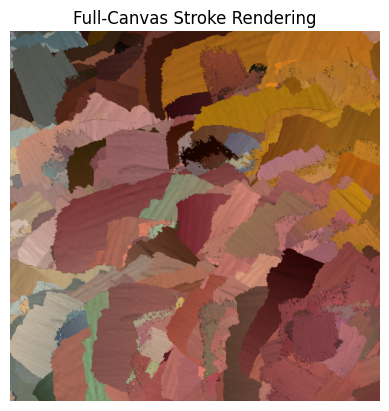

In [18]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from renderer import Renderer

# --- Load stroke data ---
data = np.load("full_canvas_strokes.npz")
x_ctt = data["x_ctt"]     # shape: [N, 5]
x_color = data["x_color"] # shape: [N, 6]
x_alpha = data["x_alpha"] # shape: [N, 1]

# --- Combine into [N, 12]
strokes = np.concatenate([x_ctt, x_color, x_alpha], axis=-1)  # shape: [N, 12]

# --- Renderer setup for full canvas ---
renderer = Renderer(renderer='oilpaintbrush', CANVAS_WIDTH=512, canvas_color='white')
renderer.create_empty_canvas()

# --- Draw all strokes ---
for stroke in strokes:
    stroke = np.array(stroke).astype(np.float32).flatten()
    if stroke.shape[0] != 12:
        continue
    renderer.stroke_params = stroke
    if renderer.check_stroke():
        renderer.draw_stroke()

# --- Save and display ---
final_canvas = renderer.canvas
img_uint8 = (final_canvas * 255).clip(0, 255).astype(np.uint8)
Image.fromarray(img_uint8).save("full_canvas_output.png")

plt.imshow(final_canvas)
plt.title("Full-Canvas Stroke Rendering")
plt.axis("off")
plt.show()
